# Capstone 2 Project: Customer Churn
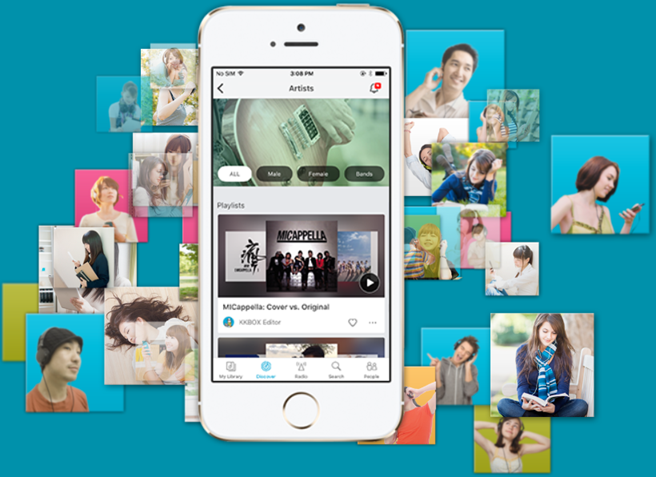

## 1. Problem Identification
### 1.1 Context
<a href="https://www.kkbox.com/">KKBOX</a> is Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. They offer a generous, unlimited version of their service to millions of people, supported by advertising and paid subscriptions. This delicate model is dependent on accurately predicting churn of their paid users.<br>
When users sign up for the service, they can choose to either manual renew or auto-renew the service, and they can cancel their membership at any time.

Build an algorithm that predicts whether a user will churn after their subscription expires. Specifically, we want to forecast if a user will make a new service subscription transaction within 30 days after the current membership expiration date.

### 1.2 Criteria for success
Prediction accuracy of the trained machine learning model does not deteriorate when applied to new, more recent data. Decision criteria are simple and interpretable. If using a decision tree, no more than 10 questions asked before making a prediction.

### 1.3 Scope of solution space
Since the majority of KKBox's subscription length is 30 days, a lot of users re-subscribe every month. The key fields to determine churn/renewal are `transaction date`, `membership expiration date`, and `is_cancel`.
The `is_cancel` field indicates whether a user actively cancels a subscription. Subscription cancellation does not imply the user has churned. A user may cancel service subscription due to change of service plans or other reasons. The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.<br>
Supervised learning methods will be used to handle this binary classification problem. Some of the records with missing and erroneous data will be placed in a separate category.

### 1.4 Constraints within solution space
The data may reveal incorrect and missing values. Such problems will be treated individually for different features and depending on the number of problems of specific kind. 

SAMPLE:<br>
The data may reveal irregularities in pricing approaches across US resorts, making it difficult to find the right strategy. A warmer or very snowy season can lead to an unpredictable decrease in the number of operating days and additional costs of making or removing excess snow. Large differences in the physical abilities of group members can lead to long waiting times on zip lines and thus to underutilization of facilities. Accidents can lead to the temporary closure of runs.

### 1.5 Stakeholders to provide key insight
There are two key stakeholders that need to be involved in this project: 1) My mentor Rahul Sagrolikar, and 2) Addison Howard, Head of Competition Program Management at Kaggle.

### 1.6 Key data sources
Data were compiled by Ann and Arden from KKBox, and are available at Kaggle
https://www.kaggle.com/c/kkbox-churn-prediction-challenge

Data are provided in 3 CSV files containing basic information about KKBOX customers, transaction details, and listening statistics.
* `members.csv`: city, `bd`, gender, registration channel, initial registration time. 6658 records.
* `transactions.csv`: payment method, duration of subscription plan, listed price, paid price, auto renewal indicator, transaction date, membership expiration date, and the churn label. 22940 records.
* `logs.csv`: date, number of songs listened below 25%, 50%, 75%, 98.5%, and 100% of their duration, number of unique songs listened, and total duration of listening. 424254 records.

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
#import warnings
#warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)

## 2.  Data Wrangling: Collect, organize, define, and clean a relevant dataset.
### 2.1 Collect Data

In [2]:
# Import data
import os
os.chdir('C:/Sereda/Lectures/Springboard/16.Feature_Engineering/')

# Data science helpers
from pathlib import Path
#!pip install featuretools==0.4.0 dask==0.19.4 distributed==1.23.3 tornado==5.0.0
import featuretools as ft

# Useful for showing multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# make some folders we will need if they do not exist
Path("./data/churn").mkdir(parents=True, exist_ok=True)

ModuleNotFoundError: No module named 'featuretools'

In [3]:
# Read in all data
members = pd.read_csv('https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/members.csv', 
                      parse_dates=['registration_init_time'], 
                      infer_datetime_format = True)

trans = pd.read_csv('https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/transactions.csv',
                   parse_dates=['transaction_date', 'membership_expire_date'], 
                    infer_datetime_format = True)

logs = pd.read_csv(f'https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/logs.csv', parse_dates = ['date'])

cutoff_times = pd.read_csv(f'https://raw.githubusercontent.com/springboard-curriculum/featuretools/master/data/MS-31_labels.csv', parse_dates = ['cutoff_time'])

In [6]:
# Save data
members.to_csv("./data/members.csv")
trans.to_csv("./data/transactions.csv")
logs.to_csv("./data/logs.csv")

### 2.2 Preliminary exploration

* `members.csv`:
    * `msno` - unique ID (1 record per members), 6658 members;
    * `city` (categorical, 20 levels: 1, 3-18, 20-22);
    * `bd` (categorical, 65 levels from 0 to 827);
    * `gender` (categorical: male, female, and 64.9% missing),
    * `registered_via` (categorical, 14 levels are 1-9, 11, 13, 16, 17, 19).
    * `registration_init_time` (date: 2004-03-27 to 2017-04-29)
* `transactions.csv`: 22940 transactions.
    * `msno`: 2434 unique member IDs (transaction information is available for 36.6% of all registered members);
    * `payment_method_id` (categorical, 31 levels: 8, 12-41);
    * `payment_plan_days` (numeric, 26 levels: 0 to 450);
    * `plan_list_price` (numeric, 31 levels: 0 to 2000);
    * `actual_amount_paid` (numeric, 31 levels: 0 to 2000);
    * `is_auto_renew` (binary 0/1, it is 1 for 85.1% of all transactions);
    * `transaction_date` (date from 2015-01-01 to 2017-03-31);
    * `membership_expire_date` (date from invalid 1970-01-01 to 2018-06-10, 1022 levels);
    * `is_cancel` (binary 0/1: 0 - no churn, 1 - churn; 3.95% of transactions are cancellations).
* `logs.csv`: `date` (date M/D/YYYY), `num_25`, `num_50`, `num_75`, `num_985`, `num_100`, `num_unq` (numeric integer), `total_secs` (numeric floating-point).

All tables have `msno` customer ID column.

In [4]:
N = members.shape[0]
print(f"There are {N} members.")

There are 6658 members.


In [5]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,8hW4+CV3D1oNM0CIsA39YljsF8M3m7g1LAX6AQd3C8I=,4,24,male,3,2014-11-04
1,yhcODfebyTYezE6KAPklcV1us9zdOYJ+7eHS7f/xgoU=,8,37,male,9,2007-02-11
2,sBlgSL0AIq49XsmBQ2KceKZNUyIxT1BwSkN/xYQLGMc=,15,21,male,3,2013-02-08
3,Xy3Au8sZKlEeHBQ+C7ro8Ni3X/dxgrtmx0Tt+jqM1zY=,1,0,NaN,9,2015-02-01
4,NiCu2GVWgT5QZbI85oYRBEDqHUZbzz2azS48jvM+khg=,12,21,male,3,2015-02-12


In [6]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6658 entries, 0 to 6657
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    6658 non-null   object        
 1   city                    6658 non-null   int64         
 2   bd                      6658 non-null   int64         
 3   gender                  2337 non-null   object        
 4   registered_via          6658 non-null   int64         
 5   registration_init_time  6658 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 312.2+ KB


### 2.3 Missing values

In [8]:
print("Proportion of non-missing gender values:", members.gender.notnull().sum()/members.gender.shape[0])
print(members.gender.unique())

Proportion of non-missing gender values: 0.35100630820066087
['male' nan 'female']


In [9]:
members.gender[members.gender.isnull()] = 'unknown' # Replace missing values with 'unknown'
print(members.gender.unique())

['male' 'unknown' 'female']


<ipython-input-9-f68cac78a34f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  members.gender[members.gender.isnull()] = 'unknown' # Replace missing values with 'unknown'


### 2.4 Further data exploration
#### members.city

In [10]:
print(f"There are {len(members.city.unique())} cities")
print("Sorted cities:", np.sort(members.city.unique()))

There are 20 cities
Sorted cities: [ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22]


In [11]:
members.city.value_counts()

1     4735
5      384
13     285
4      227
22     208
15     193
6      144
14      85
12      69
11      50
8       47
18      43
10      40
21      37
9       34
17      30
3       28
7       12
20       5
16       2
Name: city, dtype: int64

In [12]:
np.sort(members.city.unique())

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       20, 21, 22], dtype=int64)

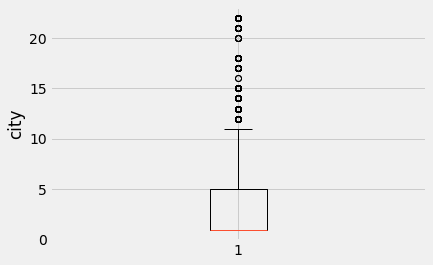

In [13]:
plt.boxplot(members.city)
plt.ylabel('city');

#### members.bd

In [14]:
print(f"No. of unique bd: {len(members.bd.unique())}")
print("Sorted bd:", np.sort(members.bd.unique()))

No. of unique bd: 65
Sorted bd: [  0   6  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  63  65  66  67
  69  70  72  90  97 103 106 112 117 132 827]


In [15]:
members.bd.value_counts()

0      4456
21      126
24      108
20      105
26      104
22      104
27       96
23       95
28       94
18       93
29       88
19       88
25       85
30       76
32       64
17       61
33       58
34       53
37       52
36       51
35       49
31       45
38       44
16       41
39       37
40       31
42       27
43       27
47       24
48       24
44       23
41       23
51       22
49       22
52       16
45       14
56       14
46       14
50       14
15       13
59       11
55        9
57        8
54        7
60        6
53        6
58        5
69        3
66        2
112       2
14        2
61        2
67        2
117       1
132       1
6         1
97        1
63        1
65        1
103       1
106       1
90        1
70        1
827       1
72        1
Name: bd, dtype: int64

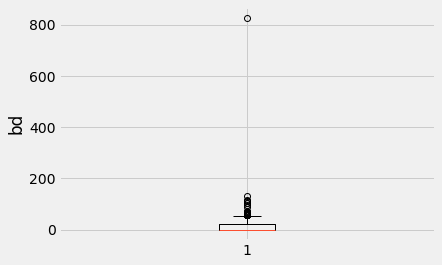

In [16]:
plt.boxplot(members.bd)
plt.ylabel('bd');

In [17]:
members.loc[members.bd > 150] # Outlier

,msno,city,bd,gender,registered_via,registration_init_time
1119,zzWbNfxs2hJmRe82uVTk+0rIhuu8MqQngjdgmc5Oerk=,5,827,female,9,2014-07-08


In [18]:
# Possible combinations of `city` and `bd`:
test= members.groupby(['city','bd'])
test.size()

city  bd 
1     0      4295
      15        2
      16       11
      17       13
      18       25
      19       28
      20       25
      21       24
      22       18
      23       11
      24       25
      25       21
      26       12
      27       19
      28       12
      29       15
      30       11
      31        8
      32       12
      33        7
      34        9
      35        7
      36        8
      37        9
      38        6
      39        6
      40       10
      41        7
      42        3
      43        9
      44        8
      45        4
      46        6
      47        5
      48        6
      49        3
      50        2
      51        5
      52        6
      53        2
      54        2
      55        2
      56        1
      57        4
      59        3
      60        3
      61        1
      66        2
      67        1
      112       1
3     0         1
      17        1
      19        3
      21        1
      22        1


#### members.gender

In [19]:
print("Unknown gender and bd=0 count:", members.gender[(members.gender=='unknown') & (members.bd == 0)].count())
print("Unknown gender and bd>0 count:", members.gender[(members.gender=='unknown') & (members.bd  > 0)].count())

Unknown gender and bd=0 count: 4283
Unknown gender and bd>0 count: 38


A small proportion 0.887% of `bd > 0` among customers with unknown gender suggests that `0` could be used to encode a missing value of `bd`.

In [20]:
members.loc[(members.gender=='unknown') & (members.bd > 0)].drop(columns='msno') # nothing special

,city,bd,gender,registered_via,registration_init_time
269,1,16,unknown,9,2016-05-23
278,5,28,unknown,9,2014-03-12
333,1,28,unknown,4,2016-10-02
634,13,22,unknown,3,2013-01-08
766,1,36,unknown,3,2014-04-28
824,3,27,unknown,9,2014-05-30
984,5,27,unknown,9,2010-12-13
1133,1,26,unknown,4,2017-01-28
1403,12,23,unknown,3,2013-02-06
1598,15,26,unknown,7,2012-12-23


Most of the missing genders are from city '1':

In [21]:
members.loc[members.gender=='unknown'].city.value_counts()

1     4206
13      23
5       17
15      15
22      11
4       11
14       8
6        5
11       5
8        4
12       4
18       4
9        3
21       2
3        2
10       1
Name: city, dtype: int64

In [22]:
members.loc[(members.gender=='unknown') & (members.bd > 0) ].city.value_counts()

1     19
13     6
5      4
15     4
3      1
12     1
4      1
14     1
11     1
Name: city, dtype: int64

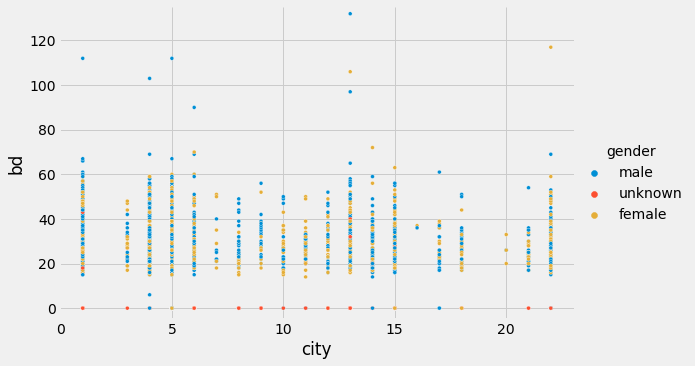

In [23]:
import seaborn as sns
sns.relplot(data=members, x='city', y='bd', hue='gender', aspect=1.6, s=15)
plt.ylim(-5, 135)
plt.show();

#### members.registered_via

In [24]:
print(f"`registered_via` has {len(members['registered_via'].unique())} levels:")

`registered_via` has 14 levels:


In [25]:
pd.crosstab(index=members['registered_via'], columns='count')

col_0,count
registered_via,
1,1
2,2
3,1648
4,2710
5,2
6,1
7,798
8,3
9,1451


In [26]:
print("%\tregistered_via")
print(f"{round(2710/N*100,1)}\t4")
print(f"{round(1648/N*100,1)}\t3")
print(f"{round(1451/N*100,1)}\t9")
print(f"{round(798/N*100,1)}\t7")

%	registered_via
40.7	4
24.8	3
21.8	9
12.0	7


#### members.registration_init_time

Earliest member registration:	 2004-03-27
Latest member registration:	 2017-04-29


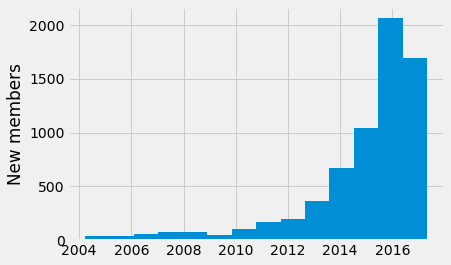

In [34]:
print("Earliest member registration:\t", np.min(members.registration_init_time).strftime('%Y-%m-%d'))
print("Latest member registration:\t", np.max(members.registration_init_time).strftime('%Y-%m-%d'))
plt.hist(members.registration_init_time, bins=2017-2003)
plt.ylabel('New members');

In [60]:
trans.shape

(22940, 9)

In [36]:
trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2017-02-10,2017-03-10,0
1,DQMPoCSc6EB39ytgnKCRsUIZnR6ZWSrHeDmX7nbxAKs=,41,30,149,149,1,2016-02-01,2016-03-02,0
2,Lrais3nsgqYwpfpSoyK3fHuPutf6cloTI5T5dQfs4lA=,38,30,149,149,0,2016-02-23,2016-04-23,0
3,ZPOjgxQw1/J7v5xgBJTCLXWuwq5Xmk33nO6AoUO1+mY=,41,30,149,119,1,2015-09-06,2016-08-01,0
4,MvR23u4bIiWM+U+VE1Mvw3qqdj/0Ixs1sf7avavjhRs=,38,30,149,149,0,2016-10-28,2016-11-27,0


#### trans.msno

In [ ]:
def nu(a):
    '''No. of unique values'''
    return len(np.unique(a))

In [145]:
nu(trans.msno)

2434

In [75]:
Ntm = len(trans.msno.unique())
print("No. of members with available transaction data:", Ntm)
print(f"Proportion of members with available transaction data: {round(len(trans.msno.unique())/N*100,1)}%")

No. of members with available transaction data: 2434
Proportion of members with available transaction data: 36.6%


<font color=red><b>Q1 Discard all members with no transaction information?</b></font>

#### trans.payment_method_id

In [48]:
trans.payment_method_id.describe()

count    22940.000000
mean        38.903575
std          3.548366
min          8.000000
25%         38.000000
50%         41.000000
75%         41.000000
max         41.000000
Name: payment_method_id, dtype: float64

In [57]:
print("Levels of payment method:", np.sort(trans.payment_method_id.unique()))

Levels of payment method: [ 8 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41]


In [69]:
vc_pm = trans.payment_method_id.value_counts()
vc_pm.head()

41    11983
40     2508
38     1851
39     1659
37     1193
Name: payment_method_id, dtype: int64

In [80]:
Nt = trans.shape[0]
print("No. of transactions:", Nt)
print("payment_method_id\t%")
for i in range(5):
    print(f"{vc_pm.index[i]}\t{round(vc_pm.iloc[i]/Nt*100,1)}")

No. of transactions: 22940
payment_method_id	%
41	52.2
40	10.9
38	8.1
39	7.2
37	5.2


Looking at one of the member's data, we see only one payment method:

In [81]:
trans.loc[trans.msno=='5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=']

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2017-02-10,2017-03-10,0
1020,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2015-11-10,2015-12-10,0
4151,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2015-10-11,2015-11-10,0
4735,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-01-10,2016-02-10,0
7267,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-02-10,2016-03-10,0
8705,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-08-10,2016-09-10,0
9597,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-05-10,2016-06-10,0
10303,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-07-10,2016-08-10,0
10909,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-09-10,2016-10-10,0
11228,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2016-10-10,2016-11-10,0


Does each member use only one payment method? No, from 1 to 5 payment methods were used by a member.

In [147]:
uv_pm = pd.pivot_table(trans, index='msno', values='payment_method_id', aggfunc=nu) # how many payment methods were used by each member
uv_pm.rename(columns = {'payment_method_id':'n_payment_methods'}, inplace = True)
uv_pm.head()

,n_payment_methods
msno,
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,1
+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2
+8BSu/tg0Y7DIY+q1S1mgHnFSQkRvb+/QVdwE7KMFU0=,1
+95t/v4J6t8a3D3ZhpsUDCL7reDGJKsDPPkRPVlGOZ4=,1
+9Q0UzM+XCIzH1BNZPFbFzvwt6QdIYd/DLn6nMt0TIU=,1


In [149]:
uv_pm.n_payment_methods.sort_values(ascending=False)

msno
Tq1aYXKTql7jPtgRCiyQ6xuMTiluycrRKG7HFl5hnSs=    5
XDvqZ7KtY0J80pbyJnqVRpI7ZFgYu9D6zYWKQImrXjA=    5
fH1Zz4lUeEsxX30G/V76NqBoHOS0vuGSFN9HjKWnCpU=    4
zfwHJ6LRTVfIhmwU6dm18f4nQhNJklA1dc/YM6tYmJE=    4
PwLdVzv98EqPz0uKoeFEKGh05Dsgldov3wlozEtN+SM=    4
                                               ..
LIzQJvG7np60EDFEiZ7FDueKgMTATASdfBhBfi1Kx1o=    1
LHjrZBjEa174FOZ4M7OirVlL8yvazN/609+xK4LjDp8=    1
LH9NrH31zn/i6p8Wihu9yO5gd0ZMLptskYYqFvXoR+o=    1
LFa6kalNBTzKg8ixv+yIC1m3KDJSXKOXxuxhhSPgcDI=    1
V91x6HpYEohG5ZdV7sk26ko2NcE/EWQ6vwI9YCGfr0k=    1
Name: n_payment_methods, Length: 2434, dtype: int64

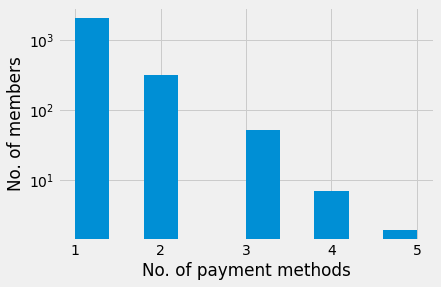

In [160]:
plt.semilogy();
uv_pm.n_payment_methods.hist();
plt.xlabel('No. of payment methods');
plt.ylabel('No. of members');

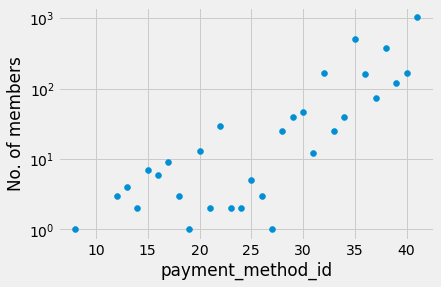

In [144]:
uv_mem = pd.pivot_table(trans, index='payment_method_id', values='msno', aggfunc=nu) # how many members used each payment method
uv_mem.rename(columns = {'msno':'n_members'}, inplace = True)
plt.semilogy()
plt.scatter(uv_mem.index, uv_mem.n_members);
plt.xlabel("payment_method_id");
plt.ylabel("No. of members");

In [175]:
print(np.sort(trans.payment_plan_days.unique()))

[  0   1   2   7  10  14  30  31  35  60  80  90 100 120 180 195 200 240
 270 360 365 395 400 410 415 450]


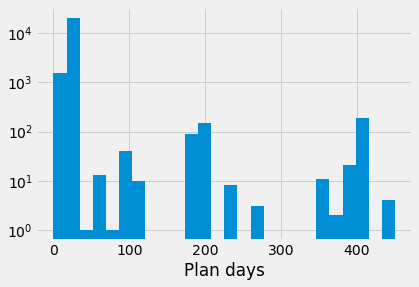

In [174]:
plt.semilogy();
trans.payment_plan_days.hist(bins=nu(trans.payment_plan_days));
plt.xlabel('Plan days');

In [191]:
print(f"Of payment_plan_days == 0, only {round(100*trans.loc[trans.payment_plan_days == 0].is_cancel.sum()/trans.loc[trans.payment_plan_days == 0].is_cancel.shape[0],2)}% transactions were cancellations.")

Of payment_plan_days == 0, only 3.25% transactions were cancellations.


In [176]:
uv_pd = pd.pivot_table(trans, index='msno', values='payment_plan_days', aggfunc=nu) # how many different plan days were used by each member
uv_pd.rename(columns = {'payment_plan_days':'n_payment_plan_days'}, inplace = True)
uv_pd.head()

,n_payment_plan_days
msno,
++bK0FRJecXCogqXdjtO2Kyb3jq7uLM7qThTk+nN8tE=,1
+0STIeZNRNVHd561CaWnwJVvjaV+FLW+pAYK6sfmKXQ=,2
+8BSu/tg0Y7DIY+q1S1mgHnFSQkRvb+/QVdwE7KMFU0=,2
+95t/v4J6t8a3D3ZhpsUDCL7reDGJKsDPPkRPVlGOZ4=,1
+9Q0UzM+XCIzH1BNZPFbFzvwt6QdIYd/DLn6nMt0TIU=,2


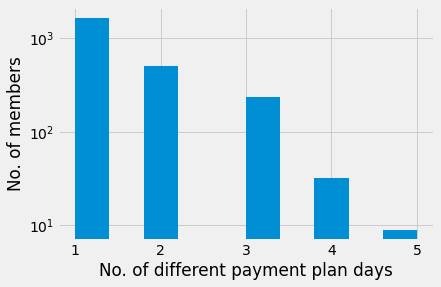

In [179]:
plt.semilogy();
uv_pd.n_payment_plan_days.hist();
plt.xlabel('No. of different payment plan days');
plt.ylabel('No. of members');

#### trans.plan_list_price

In [192]:
nu(trans.plan_list_price)

31

In [193]:
print("Levels of plan list price:", np.sort(trans.plan_list_price.unique()))

Levels of plan list price: [   0   10   35   50   99  100  119  120  129  134  149  150  180  298
  300  400  447  477  480  500  536  600  699  799  894  930 1200 1299
 1599 1788 2000]


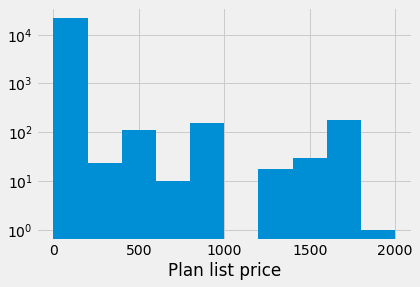

In [197]:
plt.semilogy();
trans.plan_list_price.hist();
plt.xlabel('Plan list price');


#### trans.actual_amount_paid -> discount

In [198]:
nu(trans.actual_amount_paid)

31

In [199]:
print("Levels of plan list price:", np.sort(trans.actual_amount_paid.unique()))

Levels of plan list price: [   0   10   35   50   99  100  119  120  129  134  149  150  180  298
  300  400  447  477  480  500  536  600  699  799  894  930 1200 1299
 1599 1788 2000]


In [211]:
print(f"`actual_amount_paid > plan_list_price` only when plan_list_price == {trans.loc[trans.actual_amount_paid > trans.plan_list_price].plan_list_price.unique()}")

`actual_amount_paid > plan_list_price` only when plan_list_price == [0]


In [214]:
trans.discount

0         0
1         0
2         0
3        30
4         0
         ..
22935     0
22936     0
22937     0
22938     0
22939     0
Length: 22940, dtype: int64

In [222]:
trans['discount'] = trans.plan_list_price - trans.actual_amount_paid
print(f"Discount levels: {np.sort(trans.loc[trans.discount > 0].discount.unique())}")

Discount levels: [ 20  30 120 149 180]


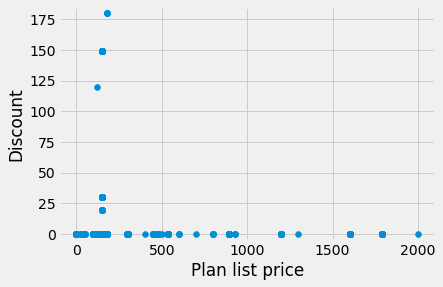

In [233]:
plt.scatter(trans.plan_list_price, trans.discount);
plt.ylim([-5,185]);
plt.xlabel('Plan list price');
plt.ylabel('Discount');

#### is_auto_renew

In [240]:
print(f"Proportion of auto renew transactions: {round(100*trans.is_auto_renew.sum()/Nt,1)}%")

Proportion of auto renew transactions: 85.1%


#### transaction_date

In [243]:
np.min(trans.transaction_date).strftime('%Y-%m-%d')

'2015-01-01'

In [244]:
np.max(trans.transaction_date).strftime('%Y-%m-%d')

'2017-03-31'

There is an overall growth in the number of transactions.

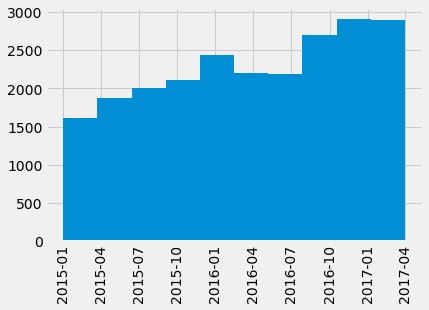

In [257]:
plt.xticks(rotation=90)
trans.transaction_date.hist();

#### membership_expire_date

In [258]:
nu(trans.membership_expire_date)

1022

Some values are invalid,

In [259]:
np.min(trans.membership_expire_date).strftime('%Y-%m-%d')

'1970-01-01'

some other are in the future,

In [260]:
np.max(trans.membership_expire_date).strftime('%Y-%m-%d')

'2018-06-10'

In [261]:
trans.msno[0]

'5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI='

In [272]:
members.loc[members.msno == trans.msno[0]].registration_init_time

1421   2010-09-23
Name: registration_init_time, dtype: datetime64[ns]

In [275]:
trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount
0,5F7G3pHKf5ijGQpoKuko0G7Jm3Bde6ktfPKBZySWoDI=,41,30,99,99,1,2017-02-10,2017-03-10,0,0
1,DQMPoCSc6EB39ytgnKCRsUIZnR6ZWSrHeDmX7nbxAKs=,41,30,149,149,1,2016-02-01,2016-03-02,0,0
2,Lrais3nsgqYwpfpSoyK3fHuPutf6cloTI5T5dQfs4lA=,38,30,149,149,0,2016-02-23,2016-04-23,0,0
3,ZPOjgxQw1/J7v5xgBJTCLXWuwq5Xmk33nO6AoUO1+mY=,41,30,149,119,1,2015-09-06,2016-08-01,0,30
4,MvR23u4bIiWM+U+VE1Mvw3qqdj/0Ixs1sf7avavjhRs=,38,30,149,149,0,2016-10-28,2016-11-27,0,0


In [278]:
def md(tn):
    '''Membership duration (days) for transaction number tn'''
    return trans.membership_expire_date[tn] - members.loc[members.msno == trans.msno[tn]].registration_init_time

In [279]:
md(0)

1421   2360 days
Name: registration_init_time, dtype: timedelta64[ns]

#### is_cancel

In [284]:
print(f"Proportion of cancellation transactions: {round(100*trans.is_cancel.sum()/Nt,2)}%")

Proportion of cancellation transactions: 3.95%
